This notebook provides an example for how to calculate the multi-model ensemble mean bias of CMIP6 data.

In [1]:
import os
import sys
       
import xarray as xr
xr.set_options(keep_attrs=True)
import numpy as np
import metpy.calc as mp

import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

%config InlineBackend.figure_format = 'retina'
dpath0='/Users/dervlamk/OneDrive/research'
dpath1=f'{dpath0}/cmip'
dpath2=f'{dpath0}/topo_biases'
dpath3=f'{dpath0}/obs_data'

In [8]:
# Custom functions that are helpful

def get_season(season='ann'):
    """
    Index months to average over to derive an annual or seasonal mean
        - can only be applied to monthly climatologies
    """
    if season in ['ANNUAL', 'ANN', 'ann']:
        mons = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    if season in ['DJF', 'djf']:
        mons = [0, 1, 11]
    if season in ['JFM', 'jfm']:
        mons = [0, 1, 2]
    if season in ['MAM', 'mam']:
        mons = [2, 3, 4]
    if season in ['JJA', 'jja']:
        mons = [5, 6, 7]
    if season in ['JJAS', 'jjas']:
        mons = [5, 6, 7, 8]
    if season in ['JAS', 'jas']:
        mons = [6, 7, 8]
    if season in ['SON', 'son']:
        mons = [8, 9, 10]
    if season==None:
        pass
    return mons

def get_xy_coords(var):
    """
    Get lon and lat arrays without knowing coordinate names
    """
    if isinstance(var, xr.DataArray):
        x,y=var.metpy.coordinates('x','y')
        return(x,y)
    if isinstance(var, xr.Dataset):
        print('This is a dataset. Please use an xarray DataArray')

def longitude_flip(var):
    """ Convert longitude values from the -180:180 to 0:360 convention or vice versa.

        ** Only works for global data. Do not apply to data with a clipped longitude range **

        Parameters
        ----------
        var : Data Array
    """
    # get var info
    x,_=get_xy_coords(var) # extract original longitude values
    lon_name=x.name        # store name of longitude coordinate
    nx=len(x)              # longitude resolution

    # determine longitude format and create an array of new lons in opposite convention
    if min(x)<0:
        # if there are negative values, data is -180:180 and need to switch to 0:360
        new_lons=np.linspace((min(x)+180), (max(x)+180), nx)
    elif max(x)>180:
        # if the max value is >180, data is in 0:360 format and need to switch to -180:180
        new_lons=np.linspace((min(x)-180), (max(x)-180), nx)

    # shift the data by 180° of longitude
    nshift=nx//2
    var=var.roll({lon_name: nshift}, roll_coords=False)

    # update longitude coord with new values
    var=var.assign_coords({lon_name: new_lons})

    # add attributes documenting change
    timestamp=datetime.now().strftime("%B %d, %Y, %r")
    var.attrs['history']=f'flipped longitudes {timestamp}'
    var.attrs['original_lons']=x.values

    return(var)

def combine_cmaps(cmap_low, cmap_up, range_low=[0,1], range_up=[0,1], n_low=128, n_up=128):
    """
    Stack two colormaps to form a new colormap
    - Use the same value for n_low and n_up to create an centered colormap

    Parameters
    ----------
    cmap_low = lower colors
    cmap_up = upper colors
    range_low = fraction of lower colormap to clip, use [0,1] to keep full range
    range_up = fraction of upper colormap to clip, use [0,1] to keep full range
    n_low = number of colors to segment lower colormap into
    n_up = number of colors to segment upper colormap into
    """
    # use the range values to determine the fraction of the original cmap to clip off and sample n colors from new range
    lower_colors = cmap_low(np.linspace(range_low[0], range_low[1], n_low))
    upper_colors = cmap_up(np.linspace(range_up[0], range_up[1], n_up))
    # combine them and build a new colormap
    colors = np.vstack((lower_colors, upper_colors))
    new_cmap = mcolors.LinearSegmentedColormap.from_list('new_cmap', colors)
    return(new_cmap)

def windSpd(u,v):
   windSpd=np.sqrt(u**2 + v**2)
   return windSpd

## Precipitation

In [3]:
## Load CMIP6 ensemble precip data
filen='data/cmip6.pr.climo.nc'
P_MODELS=xr.open_dataset(f'{dpath1}/{filen}').pr.squeeze(drop=True)


## Load GISS E2.1 PI Control data
filen='model_output/e2pt1/cpld.e2.1.output.nc'
CTRL=xr.open_dataset(f'{dpath2}/{filen}').prec[0]
# convert lons from -180:180 to 0:360
nroll=int(len(CTRL.lon)/2)
CTRL=CTRL.roll(lon=nroll)
nx=len(CTRL.lon)
CTRL['lon']=np.linspace(0,360,nx)
CTRL=CTRL.interp_like(P_MODELS,method='linear')


## Load IMERG observational precip data
filen='obs_data/satellite/imerg/imerg.climo.gn.nc'
P_OBS=xr.open_dataset(f'{dpath0}/{filen}').precipitation
P_OBS.attrs['source_id']='IMERG'
# convert lons from -180:180 to 0:360
nroll=int(len(P_OBS.lon)/2)
P_OBS=P_OBS.roll(lon=nroll)
nx=len(P_OBS.lon)
P_OBS['lon']=np.linspace(0,360,nx)
P_OBS=P_OBS.interp_like(P_MODELS,method='linear')

In [4]:
seasons = ['djf','mam','jja','son']

OBS_P_MEAN = {}
MODELS_P_MEAN = {}
CTRL_P_BIAS = {}
MEAN_P_BIAS = {}
MEAN_P_BIAS_SIGN = {}

for seas in seasons:
    mons = get_season(seas)
    
    # calculate seasonal mean climo
    OBS_P_MEAN[seas] = P_OBS[(mons),:,:].mean(dim='month')
    MODELS_P_MEAN[seas] = P_MODELS[:,(mons),:,:].mean(dim='month')
    
    # calculate GISS E2.1 seasonal mean bias
    CTRL_P_BIAS[seas] = CTRL[(mons),:,:].mean(dim='month') - OBS_P_MEAN[seas]
    
    MODEL_P_BIAS = {}
    MODEL_P_BIAS_SIGN = {}
    # calculate bias and bias direction of CMIP6 models
    for i in np.arange(0,len(P_MODELS.source_id),1):
        # model bias
        MODEL_P_BIAS[seas] = MODELS_P_MEAN[seas][i] - OBS_P_MEAN[seas]
        if i==0:
            MEAN_P_BIAS[seas] = MODEL_P_BIAS[seas]
        else:
            MEAN_P_BIAS[seas] = xr.concat([MEAN_P_BIAS[seas], MODEL_P_BIAS[seas]], dim='source_id', coords='minimal')
        # sign of bias
        MODEL_P_BIAS_SIGN[seas] = np.sign(MODEL_P_BIAS[seas])
        if i==0:
            MEAN_P_BIAS_SIGN[seas] = MODEL_P_BIAS_SIGN[seas]
        else:
            MEAN_P_BIAS_SIGN[seas] = xr.concat([MEAN_P_BIAS_SIGN[seas], MODEL_P_BIAS_SIGN[seas]], dim='source_id', coords='minimal')

In [5]:
## Index where models agree

# initialize dicts
POSITIVE_MODEL_BIAS = {}
NEGATIVE_MODEL_BIAS = {}
N_POSITIVE = {}
N_NEGATIVE = {}
P_AGREEMENT_IDX = {}
# set threshold number of models that agree for multi-model mean to be significant
n_models=len(P_MODELS.source_id)*.75

# initialize array of ones
idx=xr.zeros_like(OBS_P_MEAN['djf'])

for seas in seasons:
    # create indices where the majority of models agree on direction of change
    POSITIVE_MODEL_BIAS[seas] = MEAN_P_BIAS_SIGN[seas].where(MEAN_P_BIAS_SIGN[seas]>0,np.nan)
    NEGATIVE_MODEL_BIAS[seas] = MEAN_P_BIAS_SIGN[seas].where(MEAN_P_BIAS_SIGN[seas]<0,np.nan)
    N_POSITIVE[seas] = POSITIVE_MODEL_BIAS[seas].sum(dim='source_id')
    N_NEGATIVE[seas] = np.abs(NEGATIVE_MODEL_BIAS[seas].sum(dim='source_id'))
    P_AGREEMENT_IDX[seas] = idx.where(((N_POSITIVE[seas]>=n_models) | (N_NEGATIVE[seas]>=n_models)), 1)

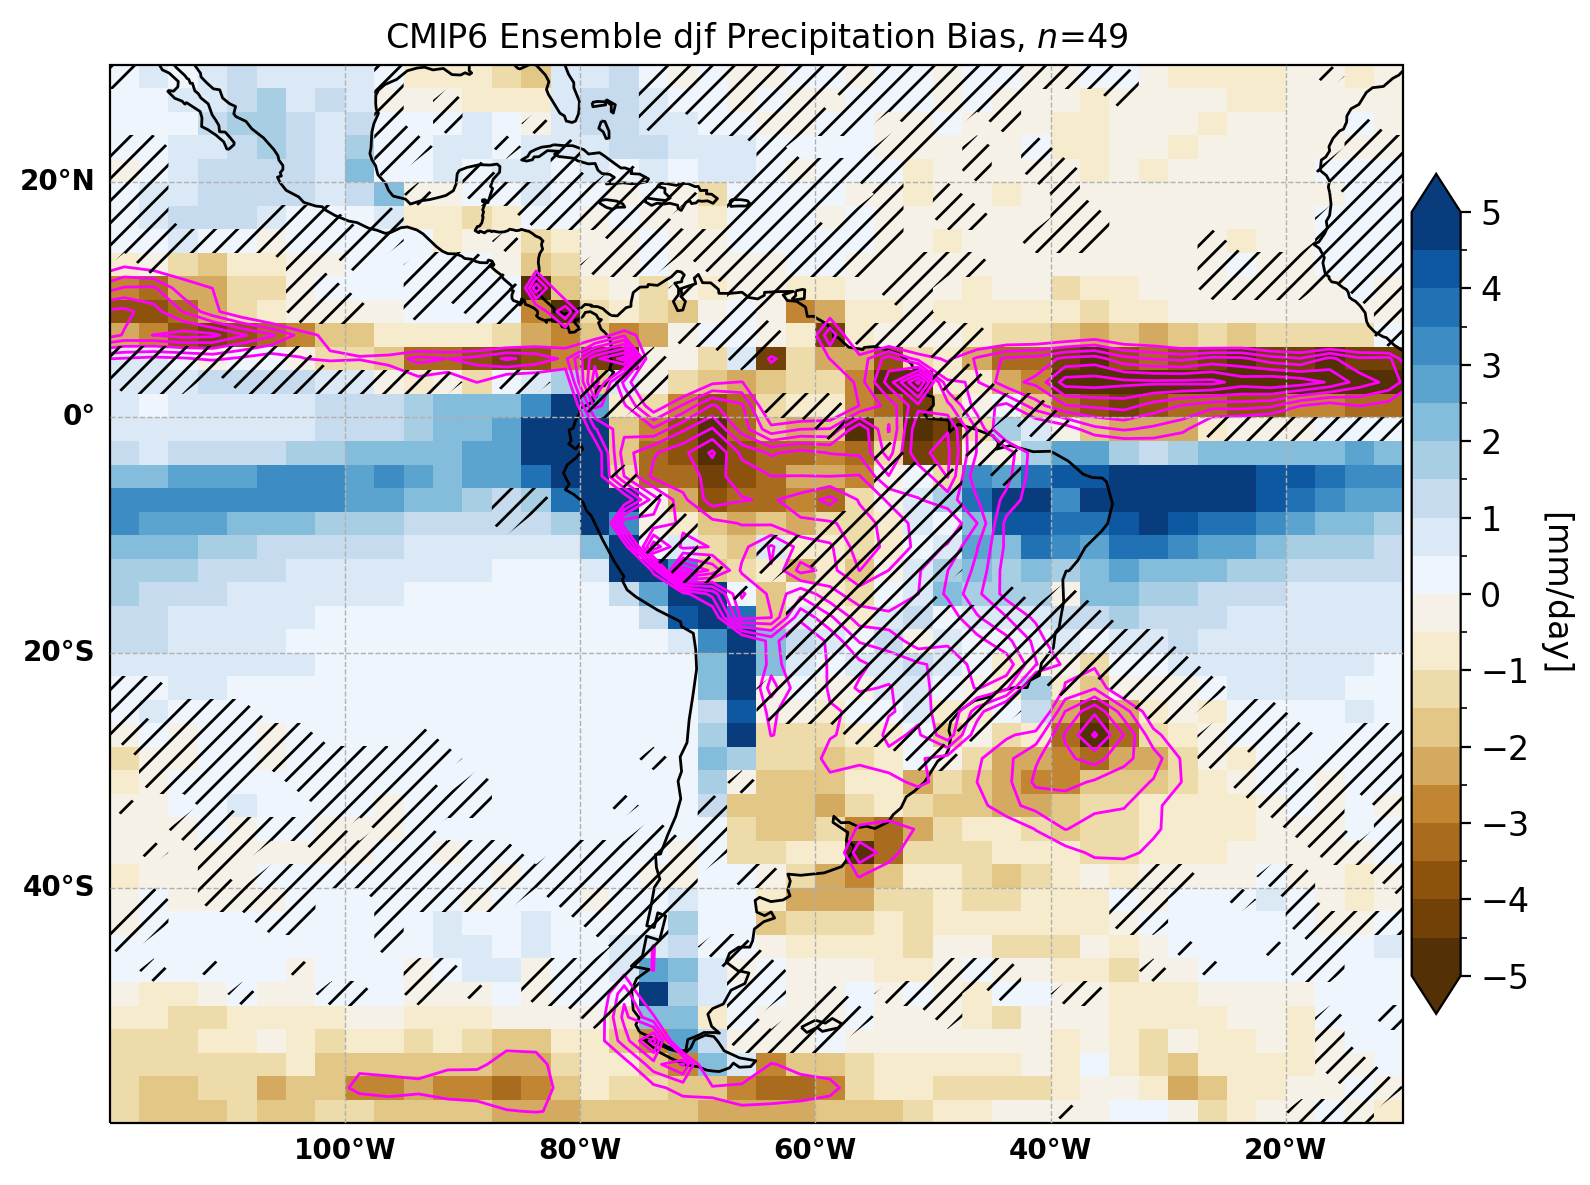

In [7]:
## Plot mean bias with hatching where models disagree
 
season='djf'

# colormap / contour info
pcmap=combine_cmaps(plt.colormaps['BrBG'], plt.colormaps['Blues'], range_low=[0,.5], range_up=[0,.95], n_low=128, n_up=128)
pvmin=-5
pvmax=5
pnorm=mpl.colors.BoundaryNorm(np.linspace(pvmin, pvmax, 21), pcmap.N)
plevels=np.linspace(5,15,11)

# map info
proj=ccrs.PlateCarree(central_longitude=180)
trans=ccrs.PlateCarree()
map_bnds=[240,350,-60,30]

# initialize figure
fig,ax=plt.subplots(nrows=1, ncols=1, figsize=(7,7), layout='constrained', subplot_kw={'projection': proj})

# set title
ax.set_title(f'CMIP6 Ensemble {season} Precipitation Bias, $n$=%i' %len(P_MODELS.source_id))

# plot Multi-Model Ensemble mean bias
cf=ax.pcolormesh(MEAN_P_BIAS[season].lon, MEAN_P_BIAS[season].lat,
                 MEAN_P_BIAS[season].mean(dim='source_id'),
                 norm=pnorm, cmap=pcmap, transform=trans) 

# add IMERG climatology contours
cs=ax.contour(OBS_P_MEAN[season].lon, OBS_P_MEAN[season].lat, OBS_P_MEAN[season],
              levels=plevels, linewidths=1, colors='fuchsia', transform=trans)
#ax.clabel(cs, cs.levels, inline=True, inline_spacing=5, fontsize=7)

# add hatching for where <75% of models agree on sign of change
ax.contourf(P_AGREEMENT_IDX[season].lon, P_AGREEMENT_IDX[season].lat, P_AGREEMENT_IDX[season],
            1, colors='none',
            hatches=['','///'],
            extend='lower', zorder=100, transform=trans)

# map formatting
ax.coastlines(color='k')
ax.set_extent(map_bnds, crs=trans)
gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
gl.left_labels=True; gl.bottom_labels=True; gl.top_labels=False; gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'color': 'black', 'weight': 'bold', 'size':10}
gl.ylabel_style={'color': 'black', 'weight': 'bold', 'size':10}

# colorbar
cax=fig.add_axes([1., 0.2, 0.035, 0.6])
cbar=fig.colorbar(cf, orientation='vertical', extend='both', cax=cax)
cbar.set_ticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])
cbar.set_label('[mm/day]', labelpad=15, rotation=270, size=12, fontweight='normal', ha='center')
cbar.ax.tick_params(labelsize=12)
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('normal')
    
    
#plt.savefig(f'{dpath1}/figs/cmip6_pr_bias_imerg_{seas}.pdf', bbox_inches='tight', transparent=True)

## U and V Winds

In [ ]:
## Load CMIP6 ensemble 10m wind data
filen=f'{dpath1}/data/cmip6.wind.climo.nc'
MODELSU=xr.open_dataset(f'{filen}').uas.squeeze(drop=True)
MODELSV=xr.open_dataset(f'{filen}').vas.squeeze(drop=True)


## Load GISS E2.1 PI Control data
filen=f'{dpath2}/model_output/e2pt1/cpld.e2.1.output.nc'
CTRLU=xr.open_dataset(f'{filen}').usurf[0]
CTRLV=xr.open_dataset(f'{filen}').vsurf[0]
# flip lons from -180:180 to 0:360
CTRLU=longitude_flip(CTRLU)
CTRLU=CTRLU.interp_like(MODELSU,method='linear')
# flip lons from -180:180 to 0:360
CTRLV=longitude_flip(CTRLV)
CTRLV=CTRLV.interp_like(MODELSV,method='linear')


## Load MERRA-2 10m reanalysis wind data
filen=f'{dpath3}/reanalysis/merra2/merra2.sfcWinds.1980-2022.monthly.nc'
OBSU10m=xr.open_dataset(f'{filen}').U10M.groupby("time.month").mean()
OBSU10m=longitude_flip(OBSU10m)
OBSU10m=OBSU10m.interp_like(MODELSU,method='linear')

OBSV10m=xr.open_dataset(f'{filen}').V10M.groupby("time.month").mean()
OBSV10m=longitude_flip(OBSV10m)
OBSV10m=OBSV10m.interp_like(MODELSV,method='linear')

In [ ]:
## Calculate bias and bias direction of data relative to obs for mean annual

OBS10mws=windSpd(OBSU10m,OBSV10m)
MODELSws=windSpd(MODELSU,MODELSV)
CTRLws=windSpd(CTRLU,CTRLV)

## CMIP6 MODELS
# calculate time-mean
OBS_W_MEAN=OBS10mws.mean(dim='month')
OBSU_MEAN=OBSU10m.mean(dim='month')
OBSV_MEAN=OBSV10m.mean(dim='month')
MODELS_W_MEAN=MODELSws.mean(dim='month')
MODELS_U_MEAN=MODELSU.mean(dim='month')
MODELS_V_MEAN=MODELSV.mean(dim='month')
CTRL_W_MEAN=CTRLws.mean(dim='month')
CTRL_U_MEAN=CTRLU.mean(dim='month')
CTRL_V_MEAN=CTRLV.mean(dim='month')

# initialize arrays
MEAN_W_BIAS=[]
MEAN_U_BIAS=[]
MEAN_V_BIAS=[]
MEAN_W_BIAS_SIGN=[]

# calculate bias and bias direction
for i in np.arange(0,len(MODELSU.source_id),1):
    # model bias
    MODEL_W_BIAS=MODELS_W_MEAN[i]-OBS_W_MEAN
    MODEL_U_BIAS=MODELS_U_MEAN[i]-OBSU_MEAN
    MODEL_V_BIAS=MODELS_V_MEAN[i]-OBSV_MEAN
    if i==0:
        MEAN_W_BIAS=MODEL_W_BIAS
        MEAN_U_BIAS=MODEL_U_BIAS
        MEAN_V_BIAS=MODEL_V_BIAS
    else:
        MEAN_W_BIAS=xr.concat([MEAN_W_BIAS,MODEL_W_BIAS], dim='source_id', coords='minimal')
        MEAN_U_BIAS=xr.concat([MEAN_U_BIAS,MODEL_U_BIAS], dim='source_id', coords='minimal')
        MEAN_V_BIAS=xr.concat([MEAN_V_BIAS,MODEL_V_BIAS], dim='source_id', coords='minimal')
    # sign of bias
    MODEL_W_BIAS_SIGN=np.sign(MODEL_W_BIAS)
    MODEL_U_BIAS_SIGN=np.sign(MODEL_U_BIAS)
    MODEL_V_BIAS_SIGN=np.sign(MODEL_V_BIAS)
    if i==0:
        MEAN_W_BIAS_SIGN=MODEL_W_BIAS_SIGN
        MEAN_U_BIAS_SIGN=MODEL_U_BIAS_SIGN
        MEAN_V_BIAS_SIGN=MODEL_V_BIAS_SIGN
    else:
        MEAN_W_BIAS_SIGN=xr.concat([MEAN_W_BIAS_SIGN,MODEL_W_BIAS_SIGN], dim='source_id', coords='minimal')
        MEAN_U_BIAS_SIGN=xr.concat([MEAN_U_BIAS_SIGN,MODEL_U_BIAS_SIGN], dim='source_id', coords='minimal')
        MEAN_V_BIAS_SIGN=xr.concat([MEAN_V_BIAS_SIGN,MODEL_V_BIAS_SIGN], dim='source_id', coords='minimal')
        
## GISS E2.1
CTRL_W_BIAS=CTRL_W_MEAN-OBS_W_MEAN
CTRL_U_BIAS=CTRL_U_MEAN-OBSU_MEAN
CTRL_V_BIAS=CTRL_V_MEAN-OBSV_MEAN

In [ ]:
## Index where models agree on sign of bias in WIND SPEED MAGNITUDE

# set threshold number of models that agree for multi-model mean to be significant
n_models=len(MODELSU.source_id)*.75

# initialize array of zeros
idx=xr.zeros_like(OBS_W_MEAN)

# create indices where the majority of models agree on direction of change
POSITIVE_MODEL_BIAS=MEAN_W_BIAS_SIGN.where(MEAN_W_BIAS_SIGN>0,np.nan)
NEGATIVE_MODEL_BIAS=MEAN_W_BIAS_SIGN.where(MEAN_W_BIAS_SIGN<0,np.nan)
N_POSITIVE=POSITIVE_MODEL_BIAS.sum(dim='source_id')
N_NEGATIVE=np.abs(NEGATIVE_MODEL_BIAS.sum(dim='source_id'))
W_AGREEMENT_IDX=idx.where(((N_POSITIVE>=n_models) | (N_NEGATIVE>=n_models)), 1)

In [ ]:
## Index where models agree on sign of bias in WIND SPEED VELOCITY

# set threshold number of models that agree for multi-model mean to be significant
n_models=len(MODELSU.source_id)*.75

# initialize array of zeros
idx=xr.zeros_like(OBS_W_MEAN)

# create indices where the majority of models agree on direction of change
POSITIVE_MODEL_U_BIAS=MEAN_U_BIAS_SIGN.where(MEAN_U_BIAS_SIGN>0,np.nan)
NEGATIVE_MODEL_U_BIAS=MEAN_U_BIAS_SIGN.where(MEAN_U_BIAS_SIGN<0,np.nan)
N_U_POSITIVE=POSITIVE_MODEL_U_BIAS.sum(dim='source_id')
N_U_NEGATIVE=np.abs(NEGATIVE_MODEL_U_BIAS.sum(dim='source_id'))
U_AGREEMENT_IDX=idx.where(((N_U_POSITIVE>=n_models) | (N_U_NEGATIVE>=n_models)), 1)

# create indices where the majority of models agree on direction of change
POSITIVE_MODEL_V_BIAS=MEAN_V_BIAS_SIGN.where(MEAN_V_BIAS_SIGN>0,np.nan)
NEGATIVE_MODEL_V_BIAS=MEAN_V_BIAS_SIGN.where(MEAN_V_BIAS_SIGN<0,np.nan)
N_V_POSITIVE=POSITIVE_MODEL_V_BIAS.sum(dim='source_id')
N_V_NEGATIVE=np.abs(NEGATIVE_MODEL_V_BIAS.sum(dim='source_id'))
V_AGREEMENT_IDX=idx.where(((N_V_POSITIVE>=n_models) | (N_V_NEGATIVE>=n_models)), 1)

UV_AGREEMENT_IDX=idx.where(((N_U_POSITIVE>=n_models) | (N_U_NEGATIVE>=n_models) | (N_V_NEGATIVE>=n_models) | (N_V_NEGATIVE>=n_models)), 1)

In [ ]:
# making more convenient variables for plotting
uvar = MEAN_U_BIAS.mean(dim='source_id')
vvar = MEAN_V_BIAS.mean(dim='source_id')
vsig = vvar.where(UV_AGREEMENT_IDX==0,np.nan)
usig = uvar.where(UV_AGREEMENT_IDX==0,np.nan)

In [ ]:
## Plot mean bias with hatching where models disagree
# cmap specs
ccmap=cm.RdBu
vmin=-2
vmax=2
levels=np.linspace(vmin, vmax, 21)
norm=mpl.colors.BoundaryNorm(levels, ccmap.N)
# vector specs
skip_n=2
w=0.015
scalef=10
key_length=2
# map specs
proj=ccrs.PlateCarree(central_longitude=-180)
trans=ccrs.PlateCarree()
lon=MEAN_U_BIAS.lon
lat=MEAN_U_BIAS.lat
map_bnds=[220,350,-60,30]

fig=plt.figure(figsize=(10, 6), layout='constrained')
ax=plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1, projection=proj)
ax.set_title('CMIP6 Ensemble Mean 10m Wind Speed Bias, $n$=%i' %len(MODELSU.source_id))

# Plot Multi-Model Ensemble mean bias
ax.pcolormesh(lon, lat, MEAN_W_BIAS.mean(dim='source_id'), vmin=vmin, vmax=vmax, cmap=ccmap, transform=trans)    
q1=ax.quiver(lon, lat,
             usig.roll(lon=360), vsig.roll(lon=360),
             color='k', width=w, scale=scalef,
             scale_units='inches', units='inches', zorder=5)
qk=ax.quiverkey(q1, .95, 1.035, key_length, rf'{key_length} m/s', labelcolor='k', labelpos='W')


ax.coastlines(color='k')
ax.set_extent(map_bnds, crs=trans)
gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
gl.bottom_labels=True; gl.left_labels=True; gl.top_labels=False; gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'color': 'black', 'weight': 'bold', 'size':12}
gl.ylabel_style={'color': 'black', 'weight': 'bold', 'size':12}

# colorbar
cf=mpl.cm.ScalarMappable(norm=norm, cmap=ccmap)
cax=fig.add_axes([1.005, 0.25, 0.0175, 0.5])
cbar=fig.colorbar(cf, orientation='vertical', extend='both', cax=cax)
cbar.set_label('$\Delta$[m/s]', y=1.125, labelpad=-30, rotation=0, size=10, fontweight='bold', ha='center')
cbar.ax.tick_params(labelsize=10)
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('bold')
    
#plt.savefig(f'cmip6_10mwind_bias_mam_pac.pdf', bbox_inches='tight', transparent=True)